<a href="https://colab.research.google.com/github/Tj-dev-py/Corona-Virus-Tweets-Classification-Project/blob/main/Corona_nlp.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Text Classification With Corona Virus Tweets

In this project, we will classify tweets about the pandemic based on their sentiment. The tweets are labelled accordingly, and are seperated into five classes: 

1. Positive
2. Negative
3. Neutral
4. Extremely Positive
5. Extremely Negative

The [data](https://www.kaggle.com/datatattle/covid-19-nlp-text-classification) is stored as a train and test set in csv files. We'll go ahead and load it into our python environment using the libraries/dependencies required to process text data. 

## Load Libraries

In [1]:
# Import  libraries
import numpy as np
import pandas as pd

import nltk
from nltk.corpus import stopwords
from nltk.stem.porter import PorterStemmer
from wordcloud import WordCloud, STOPWORDS
from nltk.stem import WordNetLemmatizer
from nltk.tokenize import word_tokenize, sent_tokenize
from bs4 import BeautifulSoup
import re, string, unicodedata
from keras.preprocessing import text, sequence
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
from sklearn.model_selection import train_test_split
from string import punctuation
import keras
from keras.models import Sequential
import tensorflow as tf

import matplotlib.pyplot as plt
import seaborn as sns

## Setup Input Pipeline

The Corona tweets dataset is a Multiclass Classification dataset. We'll get a notion of how it looks by reading it into a dataframe with Pandas.

In [2]:
# Read the files
# use python as the engine to avoid any encoding errors
train_dataset, test_dataset = pd.read_csv('/content/drive/MyDrive/Corona NLP Dataset/Corona_NLP_train.csv', 
                                          engine='python' ), \
                                          pd.read_csv('/content/drive/MyDrive/Corona NLP Dataset/Corona_NLP_test.csv', 
                                          engine='python')

# Display them
from IPython.display import display

display(train_dataset.head(), train_dataset.shape,
        test_dataset.head(), test_dataset.shape)

,UserName,ScreenName,Location,TweetAt,OriginalTweet,Sentiment
0,3799,48751,London,16-03-2020,@MeNyrbie @Phil_Gahan @Chrisitv https://t.co/i...,Neutral
1,3800,48752,UK,16-03-2020,advice Talk to your neighbours family to excha...,Positive
2,3801,48753,Vagabonds,16-03-2020,Coronavirus Australia: Woolworths to give elde...,Positive
3,3802,48754,NaN,16-03-2020,My food stock is not the only one which is emp...,Positive
4,3803,48755,NaN,16-03-2020,"Me, ready to go at supermarket during the #COV...",Extremely Negative


(41157, 6)

,UserName,ScreenName,Location,TweetAt,OriginalTweet,Sentiment
0,1,44953,NYC,02-03-2020,TRENDING: New Yorkers encounter empty supermar...,Extremely Negative
1,2,44954,"Seattle, WA",02-03-2020,When I couldn't find hand sanitizer at Fred Me...,Positive
2,3,44955,NaN,02-03-2020,Find out how you can protect yourself and love...,Extremely Positive
3,4,44956,Chicagoland,02-03-2020,#Panic buying hits #NewYork City as anxious sh...,Negative
4,5,44957,"Melbourne, Victoria",03-03-2020,#toiletpaper #dunnypaper #coronavirus #coronav...,Neutral


(3798, 6)

## Combine the data

In [3]:
data = pd.concat([train_dataset, test_dataset], axis=0)
data.head()

,UserName,ScreenName,Location,TweetAt,OriginalTweet,Sentiment
0,3799,48751,London,16-03-2020,@MeNyrbie @Phil_Gahan @Chrisitv https://t.co/i...,Neutral
1,3800,48752,UK,16-03-2020,advice Talk to your neighbours family to excha...,Positive
2,3801,48753,Vagabonds,16-03-2020,Coronavirus Australia: Woolworths to give elde...,Positive
3,3802,48754,NaN,16-03-2020,My food stock is not the only one which is emp...,Positive
4,3803,48755,NaN,16-03-2020,"Me, ready to go at supermarket during the #COV...",Extremely Negative


In [4]:
data.shape

(44955, 6)

## Find Missing Values

In [5]:
data.isnull().sum()

UserName            0
ScreenName          0
Location         9424
TweetAt             0
OriginalTweet       0
Sentiment           0
dtype: int64

## Drop duplicate data and missing values

In [6]:
data.drop_duplicates(inplace=True)
data.dropna(inplace=True)

In [7]:
data.isnull().sum()

UserName         0
ScreenName       0
Location         0
TweetAt          0
OriginalTweet    0
Sentiment        0
dtype: int64

In [8]:
data.duplicated().sum()

0

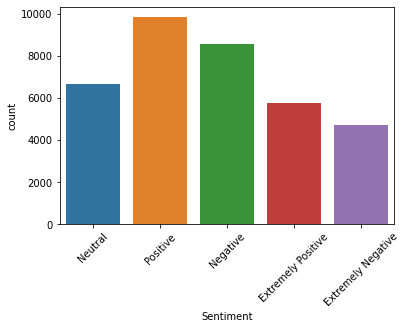

In [9]:
# checking the distribution of the classes

sns.countplot(x=data['Sentiment'])
plt.xticks(rotation=45)
plt.show()

## Reducing the number of classes

Even though there are five classes ion the data, we'll reduce them to three by mapping the extremely positive and negative classes to just positive and negative, to keep things as simple as possible.

In [10]:
data.Sentiment[data.Sentiment == 'Extremely Positive'] = 'Positive'

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


In [11]:
data.Sentiment[data.Sentiment == 'Extremely Negative'] = 'Negative'

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


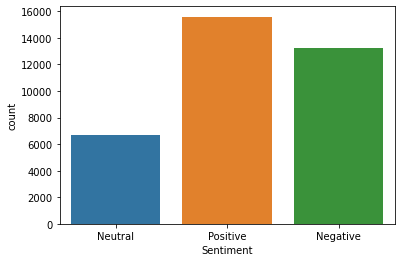

In [12]:
sns.countplot(x=data['Sentiment'])
plt.show()

## Preprocess text data

We remove things like urls/links, stopwords, hashtags, digits, html tags, numbers and so on.

In [13]:
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


True

In [14]:
# load stop words
stop_word = stopwords.words('english')

In [15]:
# our clean function

def clean(text):
  # remove urls
  text = re.sub(r'http\S+', " ", text)

  # remove mentions
  text = re.sub(r'@\w+', ' ', text)

  # remove hashtags
  text = re.sub(r'#\w+', ' ', text)

  # remove digits
  text = re.sub(r'\d+', ' ', text)

  # remove html tags
  text = re.sub(r'<.*?>', ' ', text)

  # remove stop words
  text = text.split()
  text = " ".join([word for word in text if not word in stop_word])

  return text

In [16]:
data['OriginalTweet'] = data['OriginalTweet'].apply(lambda x: clean(x))

In [17]:
data['OriginalTweet'].head()

0                                                     
1    advice Talk neighbours family exchange phone n...
2    Coronavirus Australia: Woolworths give elderly...
5    As news regions first confirmed COVID- case c...
6    Cashier grocery store sharing insights To prov...
Name: OriginalTweet, dtype: object

## Taking useful columns

Taking the OriginalTweet and Sentiment columns for our analysis.

In [18]:
useful_cols = ['OriginalTweet', 'Sentiment']

data = data[useful_cols]

## Encoding Sentiment Column

mapping the values in sentiment column to integers representing the different classes.

In [19]:
from sklearn.preprocessing import LabelEncoder
encoder = LabelEncoder()
data.Sentiment = encoder.fit_transform(data.Sentiment)

data.head()

,OriginalTweet,Sentiment
0,,1
1,advice Talk neighbours family exchange phone n...,2
2,Coronavirus Australia: Woolworths give elderly...,2
5,As news regions first confirmed COVID- case c...,2
6,Cashier grocery store sharing insights To prov...,2


## Split into train and test sets

Shuffle The Data and split it back into train and test sets.

In [20]:
from sklearn.model_selection import train_test_split

X = data.OriginalTweet.copy()
y = data.Sentiment.copy()

X_train, X_test, y_train, y_test = train_test_split(X, 
                                                    y, 
                                                    random_state=42,
                                                    train_size=.9,
                                                    )

In [21]:
display(X_train.head(), X_train.shape,
        X_test.head(), X_test.shape,
        y_train.head(), y_train.shape,
        y_test.head(), y_test.shape, 
)

31257    Amen... When going grocery store, taking walk ...
39810    One country's largest pork processing faciliti...
7778     Does supermarket vulnerable hour include group...
10333    Consequences raising prices unfairly pandemic?...
26882    Congratulations- look forward working consider...
Name: OriginalTweet, dtype: object

(31977,)

98        Spiking prices state emergency crime, REPORT IT:
12412    Last night two Dumb Things done neighborhood: ...
27393               Will get paid? [Daily Recap] $VNQ $REM
25046    worst customer service. Sold yo mother phone w...
23524    The supermarket lost charm place stay connecte...
Name: OriginalTweet, dtype: object

(3554,)

31257    1
39810    0
7778     0
10333    2
26882    2
Name: Sentiment, dtype: int64

(31977,)

98       0
12412    0
27393    1
25046    0
23524    2
Name: Sentiment, dtype: int64

(3554,)

## Maximum Length of Sequence

finding the longest sentence in the training data and test data, to adjust the parameters in preprocessing. 

In [22]:
np.max(X_train.apply(lambda x :len(x)))

286

In [23]:
np.max(X_test.apply(lambda x :len(x)))

258

In [24]:
max_len = np.max(X_train.apply(lambda x :len(x)))

## Create Tokenizer

tokenizers are used to map words to integers to feed into our neural network.

In [25]:
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences

import tensorflow as tf

In [26]:
tokenizer = Tokenizer()

In [27]:
tokenizer.fit_on_texts(X_train)
vocab_length = len(tokenizer.word_index) + 1

X_train = tokenizer.texts_to_sequences(X_train)
X_test = tokenizer.texts_to_sequences(X_test)

X_train = pad_sequences(X_train, maxlen=max_len, padding='post')
X_test = pad_sequences(X_test, maxlen=max_len, padding='post')

In [28]:
print("Vocab length:", vocab_length)
print("Max sequence length:", max_len)

Vocab length: 31121
Max sequence length: 286


In [29]:
# set embedding dimension
embedding_dim = 16

## Create Model

In [30]:
model = tf.keras.Sequential([
    tf.keras.layers.Embedding(vocab_length, embedding_dim, input_length=max_len),
    tf.keras.layers.Bidirectional(tf.keras.layers.GRU(256, return_sequences=True)),
    tf.keras.layers.GlobalAveragePooling1D(),
    tf.keras.layers.Dense(64, activation='relu'),
    tf.keras.layers.Dropout(0.4),
    tf.keras.layers.Dense(3, activation='softmax')
])
model.compile(loss='categorical_crossentropy',optimizer="adam",metrics=['accuracy'])

In [31]:
# choose between callbacks

reduce_lr = tf.keras.callbacks.ReduceLROnPlateau(
    monitor="val_loss",
    factor=0.1,
    patience=3,
    verbose=1,
    mode="auto",
    min_delta=0.01,
)

early_stoppping = tf.keras.callbacks.EarlyStopping(
    monitor="val_loss",
    min_delta=.01,
    patience=3,
    verbose=1,
    mode="auto",
    restore_best_weights=True,
)

In [32]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, 286, 16)           497936    
_________________________________________________________________
bidirectional (Bidirectional (None, 286, 512)          420864    
_________________________________________________________________
global_average_pooling1d (Gl (None, 512)               0         
_________________________________________________________________
dense (Dense)                (None, 64)                32832     
_________________________________________________________________
dropout (Dropout)            (None, 64)                0         
_________________________________________________________________
dense_1 (Dense)              (None, 3)                 195       
Total params: 951,827
Trainable params: 951,827
Non-trainable params: 0
__________________________________________________

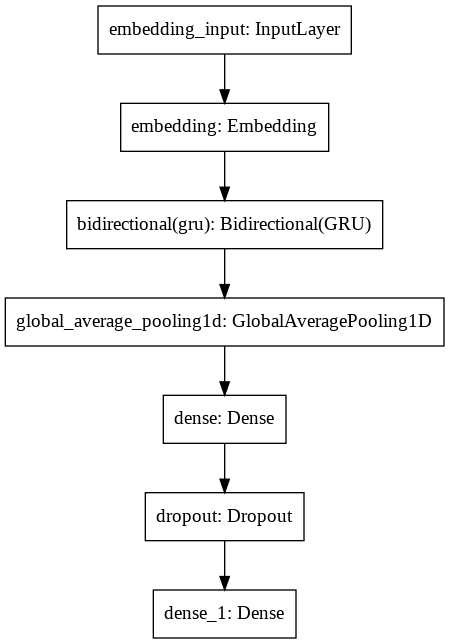

In [33]:
tf.keras.utils.plot_model(model)

## Train Model

In [34]:
X_train.shape, y_train.shape, X_test.shape, y_test.shape

((31977, 286), (31977,), (3554, 286), (3554,))

In [35]:
from tensorflow.keras.utils import to_categorical

y_train = to_categorical(y_train, 3)
y_test = to_categorical(y_test, 3)

In [36]:
history = model.fit(X_train, 
                    y_train, 
                    epochs=10,
                    validation_data=(X_test, y_test),
                    callbacks=[early_stoppping], 
                    verbose=1)

Epoch 1/10
1000/1000 [==============================] - 143s 135ms/step - loss: 0.9170 - accuracy: 0.5522 - val_loss: 0.7239 - val_accuracy: 0.7079
Epoch 2/10
1000/1000 [==============================] - 134s 134ms/step - loss: 0.6276 - accuracy: 0.7666 - val_loss: 0.6316 - val_accuracy: 0.7651
Epoch 3/10
1000/1000 [==============================] - 134s 134ms/step - loss: 0.4731 - accuracy: 0.8301 - val_loss: 0.5154 - val_accuracy: 0.8140
Epoch 4/10
1000/1000 [==============================] - 134s 134ms/step - loss: 0.3130 - accuracy: 0.8977 - val_loss: 0.5045 - val_accuracy: 0.8298
Epoch 5/10
1000/1000 [==============================] - 134s 134ms/step - loss: 0.2315 - accuracy: 0.9281 - val_loss: 0.5385 - val_accuracy: 0.8354
Epoch 6/10
1000/1000 [==============================] - 133s 133ms/step - loss: 0.1671 - accuracy: 0.9501 - val_loss: 0.5855 - val_accuracy: 0.8427
Epoch 7/10
1000/1000 [==============================] - 134s 134ms/step - loss: 0.1286 - accuracy: 0.9602 - val_

In [37]:
history_df = pd.DataFrame(history.history)

history_df

,loss,accuracy,val_loss,val_accuracy
0,0.916961,0.552209,0.723853,0.707935
1,0.627643,0.766582,0.631616,0.765053
2,0.473090,0.830128,0.515400,0.814012
3,0.313010,0.897708,0.504476,0.829769
4,0.231521,0.928136,0.538524,0.835397
5,0.167125,0.950089,0.585513,0.842712
6,0.128638,0.960221,0.672807,0.844401


In [38]:
acc = history_df.accuracy
loss = history_df.loss

val_acc = history_df.val_accuracy
val_loss = history_df.val_loss

## Visualizing results

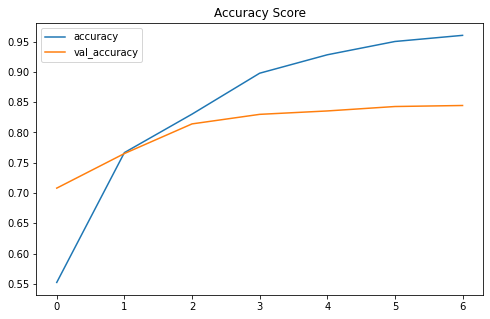

In [39]:
plt.figure(figsize=(8, 5))

plt.plot(acc)
plt.plot(val_acc)

plt.legend(['accuracy', 'val_accuracy'])
plt.title('Accuracy Score')

plt.show()

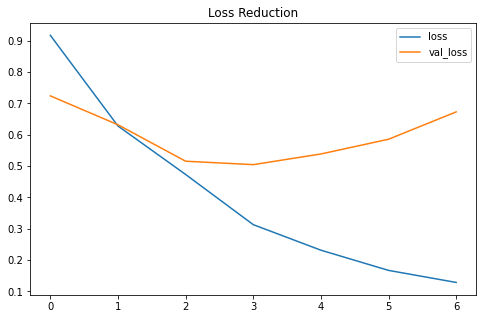

In [40]:
plt.figure(figsize=(8, 5))

plt.plot(loss)
plt.plot(val_loss)

plt.legend(['loss', 'val_loss'])
plt.title('Loss Reduction')

plt.show()

## Saving Model

In [42]:
tf.keras.models.save_model(model,'corona_nlp.hdf5')